$\newcommand{\calf}{{\cal F}}
\newcommand{\dnu}{d \nu}
\newcommand{\mf}{{\bf F}}
\newcommand{\vu}{{\bf u}}
\newcommand{\ve}{{\bf e}}
\newcommand{\mg}{{\bf G}}
\newcommand{\ml}{{\bf L}}
\newcommand{\mg}{{\bf G}}
\newcommand{\mi}{{\bf I}}
\newcommand{\diag}{\mbox{diag}}
\newcommand{\begeq}{{\begin{equation}}}
\newcommand{\endeq}{{\end{equation}}}
$

In [4]:
include("mprnote.jl")

# Newton's Method in Multiple Precision: C. T. Kelley

This notebook documents the results in 
C. T. Kelley, ***Newton's Method in Mixed Precision***, 2020.<cite data-cite="ctk:sirev20"><a href="newtonmp.html#ctk:sirev20">(Kel20)</cite><br>

As an example we will solve the Chandrasekhar H-equation <cite data-cite="chand"><a href="newtonmp.html#chand">(Cha60)</cite>. This equation, which we describe in detail in the Example section, has a fast $O(N \log(N))$ function evaluation, a Jacobian evaluation that is $O(N^2)$ work analytically and $O(N^2 \log(N))$ with a finite difference. This means that most of the work, if you do things right, is in the LU factorization of the Jacobian. 
    
The difference between double, single, and half precision will be clear in the results from the examples. This notebook has no half-precision computations. Julia does half-precsion in software and that is very slow.
  

## Contents

- [Example: The Chandrasekhar H-Equation](#The-Chandrasekhar-H-Equation): Integral equations example

- [Setting up the notebook](#Setting-up): Install the application.

- [First run of the solver](#Running-the-solver): First solver teset

- [How to use the solver](#NSOLD): Using nsold.jl, __version .01!!!__

- [The results in the paper](#The-results-in-the-paper): Running the codes that generated the results

## The Chandrasekhar H-Equation




The example is the mid-point rule discretization of the Chandrasekhar H-equation <cite data-cite="chand"><a href="newtonmp.html#chand">(Cha60)</cite>.
    
    
 
   \begin{equation}
    {\calf}(H)(\mu) = H(\mu) -
\left(
1 - \frac{c}{2} \int_0^1 \frac{\mu H(\mu)}{\mu + \nu} \dnu
\right)^{-1} = 0.
    \end{equation}
    
    
The nonlinear operator $\calf$ is defined on $C[0,1]$, the space of
continuous functions on $[0,1]$.  

The equation has a well-understood dependence on the parameter $c$
<cite data-cite="twm68"><a href="newtonmp.html#twm68">(Mul68)</cite>,
    <cite data-cite="ctk:n1"><a href="newtonmp.html#ctk:n1">(DK80)</cite>.
The equation has unique solutions at $c=0$
and $c=1$ and two solutions for $0 < c < 1$. There is a simple fold
singularity 
        <cite data-cite="herb"><a href="newtonmp.html#herb">(Kel87)</cite>
        at $c=1$. Only one 
        <cite data-cite="chand"><a href="newtonmp.html#chand">(Cha60)</cite>,
        <cite data-cite="busb"><a href="newtonmp.html#busb">(Bus60)</cite>
            of the two solutions for $0 < c < 1$ is of physical interest
and that is the one easiest to find numerically. One must do
a continuation computation to find the other one.

The structure of the singularity is preserved if one discretizes
the integral with any rule that integrates constants exactly. For
the purposes of this paper the composite midpoint rule will suffice.
The $N$-point composite midpoint rule is
\begin{equation}
\int_0^1 f(\nu) \dnu \approx \frac{1}{N} \sum_{j=1}^N f(\nu_j)
\end{equation}
where $\nu_j = (j - 1/2)/N$ for $1 \le j \le N$. This rule is
second-order accurate for sufficiently smooth functions $f$. The
solution of the integral equation is, however, not smooth enough. $H'(\mu)$
has a logarithmic singularity at $\mu=0$.

The discrete problem is

\begin{equation}
\mf(\vu)_i \equiv
u_i - \left(
1  - \frac{c}{2N} \sum_{j=1}^N \frac{u_j \mu_i}{\mu_j + \mu_i}
\right)^{-1}
=0.
\end{equation}

One can simplify the approximate integral operator
and expose some useful structure. Since


\begin{equation}
\frac{c}{2N} \sum_{j=1}^N \frac{u_j \mu_i}{\mu_j + \mu_i}
= \frac{c (i - 1/2) }{2N} \sum_{j=1}^N \frac{u_j}{i+j -1}.
\end{equation}


hence the approximate integral operator is
the product of a diagonal matrix and a Hankel matrix and
one can use an FFT to evaluate that operator with $O(N \log(N))$
work 
<cite data-cite="golub"><a href="newtonmp.html#golub">(GV96)</cite>.
    
We can express the approximation of the integral operator in matrix
form
\begin{equation}
(\ml \vu)_i = \frac{c (i - 1/2) }{2N} \sum_{j=1}^N \frac{u_j}{i+j -1}
\end{equation}
and compute the Jacobian analytically as
\begin{equation}
\mf'(\vu) = \mi - \diag(\mg(\vu))^2 \ml
\end{equation}
where
\begin{equation}
\mg(\vu)_i = \left(
1  - \frac{c}{2N} \sum_{j=1}^N \frac{u_j \mu_i}{\mu_j + \mu_i}
\right)^{-1}.
\end{equation}
Hence the data for the Jacobian is already available after
one computes $\mf(\vu) = \vu - \mg(\vu)$ and the Jacobian can
be computed with $O(N^2)$ work.
We do that in this example and therefore the only $O(N^3)$
part of the solve is the matrix factorization.

One could also approximate the Jacobian with forward differences.
In this case one approximates the $j$th column $\mf'(\vu)_j$
of the Jacobian with
\begin{equation}
\frac{\mf(\vu + h {\tilde \ve}_j) - \mf(\vu)}{h}
\end{equation}
where ${\tilde \ve}_j$ is a unit vector in the $j$th coordinate
direction and $h$ is a suitable difference increment. If one computes
$\mf$ in double precision with unit roundoff $u_d$, then
$h =O(\| \vu \| \sqrt{u_d})$ is a reasonable choice 
<cite data-cite="ctk:roots"><a href="newtonmp.html#ctk:roots">(Kel95)</cite>.
Then
the error in the Jacobian is $O(\sqrt{u_d}) = O(u_s)$ where $u_s$ is
unit roundoff in single precision. The cost of a finite difference Jacobian
in this example is $O(N^2 \log(N))$ work.

The analysis in  <cite data-cite="ctk:sirev20"><a href="newtonmp.html#ctk:sirev20">(Kel20)</cite> suggests that there
is no significant difference in the nonlinear iteration
from either the choice of analytic or finite difference Jacobians
or the choice of single or double precision for the linear solver. This notebook has the data used in that paper
to support that assertion. You will be able to duplicate the results and play with the codes.
    
Half precision is another story and we have those codes for you, too.
    


## Setting up



You need to install these packages with __Pkg__. I assume you know how to do that.

- SIAMFANLEquations
- PyPlot
- LinearAlgebra
- Printf
- IJulia (You must have done this already or you would not be looking at this notebook.)

The directory is a Julia project. So all you should need to do to get going is to run the first code cell in this notebook. That cell has one line

```
include("mprnote.jl")
```

Then you can do a simple solve and test that you did it right by typing
```Julia
hout=heqtest()
```
which I will do in the next code cell. Now ...

**Make absolutely sure that you are in the MPResults directory**. Then ...


## Running the solver

The codes solve the H-equation and plot/tabulate the results in various ways. __heqtest__ prints on column of the tables in Chandrasekhar's book. It calls __nsold.jl__ . I've shown you the output from the solver but that is not important for now. You get the details on the solver in the next section.

In [2]:
heqtest()

0.00e+00      1.00000e+00 
5.00e-02      1.04424e+00 
1.00e-01      1.07236e+00 
1.50e-01      1.09470e+00 
2.00e-01      1.11346e+00 
2.50e-01      1.12965e+00 
3.00e-01      1.14389e+00 
3.50e-01      1.15657e+00 
4.00e-01      1.16797e+00 
4.50e-01      1.17830e+00 
5.00e-01      1.18773e+00 
5.50e-01      1.19638e+00 
6.00e-01      1.20435e+00 
6.50e-01      1.21172e+00 
7.00e-01      1.21856e+00 
7.50e-01      1.22493e+00 
8.00e-01      1.23088e+00 
8.50e-01      1.23646e+00 
9.00e-01      1.24169e+00 
9.50e-01      1.24662e+00 
1.00e+00      1.25126e+00 

 
 
[1.54457e+00, 7.94167e-03, 1.55209e-07, 2.39149e-15, 1.61651e-15, 1.36877e-15, 1.47288e-15, 1.76242e-15, 2.20932e-15, 1.50598e-15, 1.06489e-15]


(exactout = (solution = [1.00707e+00, 1.01754e+00, 1.02622e+00, 1.03392e+00, 1.04094e+00, 1.04744e+00, 1.05352e+00, 1.05925e+00, 1.06469e+00, 1.06986e+00  …  1.24220e+00, 1.24320e+00, 1.24419e+00, 1.24517e+00, 1.24614e+00, 1.24709e+00, 1.24804e+00, 1.24897e+00, 1.24989e+00, 1.25081e+00], functionval = [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00  …  0.00000e+00, 2.22045e-16, 0.00000e+00, -2.22045e-16, 0.00000e+00, 2.22045e-16, 0.00000e+00, 0.00000e+00, 2.22045e-16, 0.00000e+00], history = [1.54457e+00, 7.94167e-03, 1.55209e-07, 2.39149e-15, 1.61651e-15, 1.36877e-15, 1.47288e-15, 1.76242e-15, 2.20932e-15, 1.50598e-15, 1.06489e-15], stats = (ifun = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], ijac = [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], iarm = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), idid = false, errcode = 10), fdout = (solution = [1.00707e+00, 1.01754e+00, 1.02622e+00, 1.03392e+00, 1.04094e+00, 1.04744e+00, 1.05352e+00,

heqtest.jl, calls the solver and harvests some iteration statistics. The two columns of numbers are the reults from <cite data-cite="chand"><a href="newtonmp.html#chand">(Cha60)</cite> (page 125). The iteration statistics are from nsold.jl, the solver.

##  NSOL

The solver is ```nsol``` from my pacakge [SIAMFANLEquations.jl](#https://github.com/ctkelley/SIAMFANLEquations.jl)
<cite data-cite="ctk:fajulia"><a href="siamfa.html#ctk:fajulia">(Kel20d)</cite>. That pacackage and an 
[IJulia Notebook](#https://github.com/ctkelley/NotebookSIAMFANL) 
<cite data-cite="ctk:notebooknl"><a href="siamfa.html#ctk:notebooknl">(Kel20b)</cite>    
support my upcoming book __Solving Nonlinear Equations with Iterative Methods:
Solvers and Examples in Julia__
<cite data-cite="ctk:siamfanl"><a href="siamfa.html#ctk:siamfanl">(Kel20c)</cite>
The solver and the H-equation example are both from that package. When you run the first code cell you are set up.



## Using nsol.jl

At the level of this notebook, it's pretty simple. Remember that Julia hates to allocate memory. So your function and Jacobian evaluation routines should expect the calling function to **preallocate** the storage for both the function and Jacobian. Your functions will then use __.=__ to put the function and Jacobian where they are supposed to be.

It's worthwhile to look at the help screen. 

In [5]:
?nsol

search: nsol nsolsc transcode transpose Transpose transpose! DimensionMismatch



```
nsol(F!, x0, FS, FPS, J!=diffjac!; rtol=1.e-6, atol=1.e-12,
           maxit=20, solver="newton", sham=5, armmax=10, resdec=.1,
           dx = 1.e-7, armfix=false, 
           pdata = nothing, jfact = klfact,
           printerr = true, keepsolhist = false, stagnationok=false)
```

)

C. T. Kelley, 2020

Julia versions of the nonlinear solvers from my SIAM books.  Herewith: nsol

You must allocate storage for the function and Jacobian in advance –> in the calling program <– ie. in FS and FPS

Inputs:

  * F!: function evaluation, the ! indicates that F! overwrites FS, your   preallocated storage for the function.

    So FS=F!(FS,x) or FS=F!(FS,x,pdata) returns FS=F(x)

  * x0: initial iterate

  * FS: Preallocated storage for function. It is an N x 1 column vector

  * FPS: preallocated storage for Jacobian. It is an N x N matrix

  * J!: Jacobian evaluation, the ! indicates that J! overwrites FPS, your   preallocated storage for the Jacobian. If you leave this out the   default is a finite difference Jacobian.

    So, FP=J!(FP,FS,x) or FP=J!(FP,FS,x,pdata) returns FP=F'(x). 

    (FP,FS, x) must be the argument list, even if FP does not need FS.   One reason for this is that the finite-difference Jacobian   does and that is the default in the solver.
  * Precision: Lemme tell ya 'bout precision. I designed this code for    full precision functions and linear algebra in any precision you want.    You can declare   FPS as Float64, Float32, or Float16 and nsol will do the right thing if   YOU do not destroy the declaration in your J! function. I'm amazed   that this works so easily. If the Jacobian is reasonably well    conditioned, you can cut the cost of Jacobian factorization and   storage in half with no loss. For large dense Jacobians and inexpensive   functions, this is a good deal.

    BUT ... There is very limited support for direct sparse solvers in   anything other than Float64. I recommend that you only use Float64   with direct sparse solvers unless you really know what you're doing. I   have a couple examples in the notebook, but watch out.

---

Keyword Arguments (kwargs):

  * rtol and atol: relative and absolute error tolerances

  * maxit: limit on nonlinear iterations

solver: default = "newton"

Your choices are "newton" or "chord". However, you have sham at your disposal only if you chose newton. "chord" will keep using the initial derivative until the iterate converges, uses the iteration budget, or the line search fails. It is not the same as sham=Inf, which is smarter.

sham: default = 5 (ie Newton)

This is the Shamanskii method. If sham=1, you have Newton. The iteration updates the derivative every sham iterations. The convergence rate has local q-order sham+1 if you only count iterations where you update the derivative. You need not provide your own derivative function to use this option. sham=Inf is chord only if chord is converging well.

I made sham=1 the default for scalar equations. For systems I'm more aggressive and want to invest as little energy in linear algebra as possible. So the default is sham=5.

armmax: upper bound on step size reductions in line search

resdec: default = .1

This is the target value for residual reduction. The default value is .1. In the old MATLAB codes it was .5. I only turn Shamanskii on if the residuals are decreasing rapidly, at least a factor of resdec, and the line search is quiescent. If you want to eliminate resdec from the method ( you don't ) then set resdec = 1.0 and you will never hear from it again.

dx: default = 1.e-7

difference increment in finite-difference derivatives       h=dx*norm(x,Inf)+1.e-8

armfix: default = false

The default is a parabolic line search (ie false). Set to true and the step size will be fixed at .5. Don't do this unless you are doing experiments for research.

pdata:

precomputed data for the function/Jacobian.  Things will go better if you use this rather than hide the data  in global variables within the module for your function/Jacobian

jfact: default = klfact (tries to figure out best choice) 

If your Jacobian has any special structure, please set jfact to the correct choice for a factorization.

I use jfact when I call PrepareJac! to evaluate the Jacobian (using your J!) and factor it. The default is to use klfact (an internal function) to do something reasonable. For general matrices, klfact picks lu! to compute an LU factorization and share storage with the Jacobian.  You may change LU to something else by, for example, setting jfact = cholseky! if your Jacobian is spd.

klfact knows about banded matrices and picks qr. You should, however RTFM, allocate the extra two upper bands, and use jfact=qr! to override klfact.

If you give me something that klfact does not know how to dispatch on, then nothing happens. I just return the original Jacobian matrix and  nsol will use backslash to compute the Newton step. I know that this is probably not optimal in your situation, so it is  good to pick something else, like jfact = lu.

Please do not mess with the line that calls PrepareJac!. 

```
    FPF = PrepareJac!(FPS, FS, x, ItRules)
```

FPF is not the same as FPS (the storage you allocate for the Jacobian) for a reason. FPF and FPS do not have the same type, even though they share storage. So, FPS=PrepareJac!(FPS, FS, ...) will break things.

printerr: default = true

I print a helpful message when the solver fails. To suppress that message set printerr to false.

keepsolhist: default = false

Set this to true to get the history of the iteration in the output tuple. This is on by default for scalar equations and off for systems. Only turn it on if you have use for the data, which can get REALLY LARGE.

stagnationok: default = false

Set this to true if you want to disable the line search and either observe divergence or stagnation. This is only useful for research or writing a book.

Output:

A named tuple (solution, functionval, history, stats, idid,                errcode, solhist) where

solution = converged result functionval = F(solution) history = the vector of residual norms (||F(x)||) for the iteration stats = named tuple of the history of (ifun, ijac, iarm), the number of functions/derivatives/steplength reductions at each iteration.

I do not count the function values for a finite-difference derivative because they count toward a Jacobian evaluation. 

idid=true if the iteration succeeded and false if not.

errcode = 0 if if the iteration succeeded         = -1 if the initial iterate satisfies the termination criteria         = 10 if no convergence after maxit iterations         = 1  if the line search failed

solhist:

This is the entire history of the iteration if you've set keepsolhist=true

solhist is an N x K array where N is the length of x and K is the number of iteration + 1. So, for scalar equations, it's a row vector.

---

# Examples

#### World's easiest problem example. Test 64 and 32 bit Jacobians. No meaningful difference in the residual histories or the converged solutions.

```jldoctest
 julia> function f!(fv,x)
       fv[1]=x[1] + sin(x[2])
       fv[2]=cos(x[1]+x[2])
       end
f (generic function with 1 method)

julia> x=ones(2,); fv=zeros(2,); jv=zeros(2,2); jv32=zeros(Float32,2,2);
julia> nout=nsol(f!,x,fv,jv; sham=1);
julia> nout32=nsol(f!,x,fv,jv32; sham=1);
julia> [nout.history nout32.history]
5×2 Array{Float64,2}:
 1.88791e+00  1.88791e+00
 2.43119e-01  2.43119e-01
 1.19231e-02  1.19231e-02
 1.03266e-05  1.03262e-05
 1.46416e-11  1.43548e-11

julia> [nout.solution nout.solution - nout32.solution]
2×2 Array{Float64,2}:
 -7.39085e-01  -5.42899e-14
  2.30988e+00   3.49498e-13
```

#### H-equation example. I'm taking the sham=5 default here, so the convergence is not quadratic. The good news is that we evaluate the Jacobian only once.

```jldoctest
julia> n=16; x0=ones(n,); FV=ones(n,); JV=ones(n,n);
julia> hdata=heqinit(x0, .5);
julia> hout=nsol(heqf!,x0,FV,JV;pdata=hdata);
julia> hout.history
4-element Array{Float64,1}:
 6.17376e-01
 3.17810e-03
 2.75227e-05
 2.35817e-07
```


## How nsol.jl controls the precision of the Jacobian

You can control the precision of the Jacobian by simply allocating FPS in your favorite precision. So if I have a problem with N=256 unknowns I will declare FP as zeros(N,1) and may declare FPS as zeros(N,N) or Float32.(zeros(N,N)).

Note the __.__ between Float32 and the paren. This, as is standard Julia practice, applies the conversion to Float32 to everyelement in the array. If you forget the __.__ Julia will complain.

# The results in the paper



The paper has plots for double, single, and half precsion computations for c=.5, .99, and 1.0. The half precision results take a very long time to get. On my computer (2019 iMac; 8 cores, 64GB of memory) the half precision compute time was over two weeks. Kids, don't try this at home.

The data for the paper are in the cleverly named directory __Data_From_Paper__

__cd to the directory MPResults__ and __from that directory__ run

```Julia
data_harvest("Data_From_Paper/MP_Data_") 
```

at the julia prompt you will generate all the tables and plots in the paper.

If you have the time and patience you can also generate the data with __data_populate.jl__. This create three directories named Mixed_Precision_c=? and you can see for yourself. Look at that file to see opportunities to edit the time-cosumng jobs out. If you eliminate the half precision work and the larger dimensions, the code will run in a short time. 

__data_populate__(c; half="no",level=p) does double and single preicsion solves for $1024 \times 2^k$ point grids for k=0, ... p-1 . Set half="yes" to make the computations take much longer.

Here is a simple example of using data_populate and the plotter code plot_nsold.jl. I'm only using the 1024, 2048 and 4096 point grids. The plot in the paper uses more levels. This is part of Figure 1 in the paper.

Look at the source to __data_populate.jl__ and __plotnsold.jl__ and you'll see how I did this. These codes only mange files, plots, and tables. There is nothing really exciting here. You don't need to know much Julia to understand this, but you do need to know something and I can't help with that.

To begin with, I will create a directory called Data_Test to put all this stuff. I will cd to that directory.

In [4]:
cd(MPRdir)
Home4mp="Data_Test"
try (mkdir(Home4mp))
catch
end
cd(Home4mp)
pwd()

"/Users/ctk/Dropbox/Julia/dev/MPResults/Data_Test"

Now I'll run __data_populate__ to create a subdirectory with the data. cd to that directory and run __plotnsold__. That's how I created the plots in the paper with all values of *c* and all the problem sizes. The half precision computation took two weeks.

__plotnsold("no",c,10,3;title)__ makes the four-plot with only double and single (no half).

Even with this small problem, __data_populate__ takes a while. Be patient. Once it's done the plots will appear
pretty rapidly.

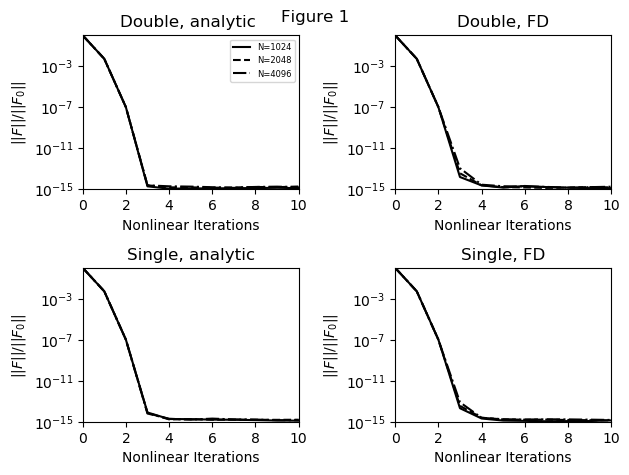

PyObject Text(0.5, 0.98, 'Figure 1')

In [5]:
using PyPlot
data_populate(.5;half="no",level=3)
# after data_populate's done, the plots happen fast
cd("Mixed_Precision_c=5")
figtitle="Figure 1"
plotnsold("no",.5,10,3;bigtitle=figtitle)

Finally, I will duplicate the tables and plots in the paper with the precomputed data in the Data_From_Paper directory. The plots and tables come from __data_harvest.jl__. First the plots ...



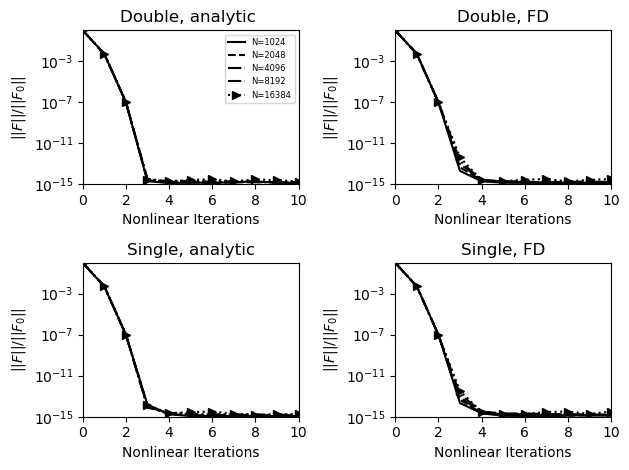

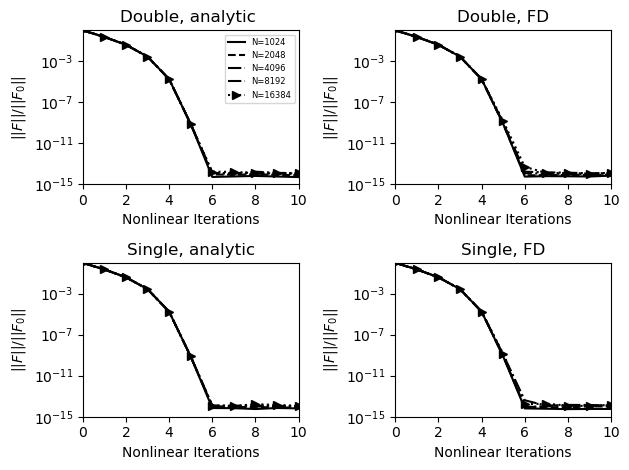

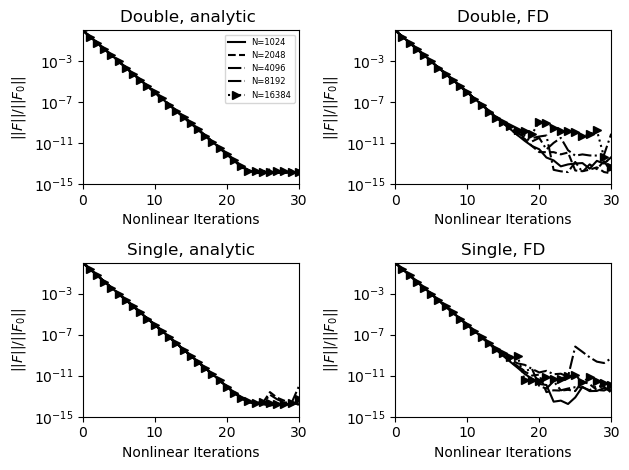

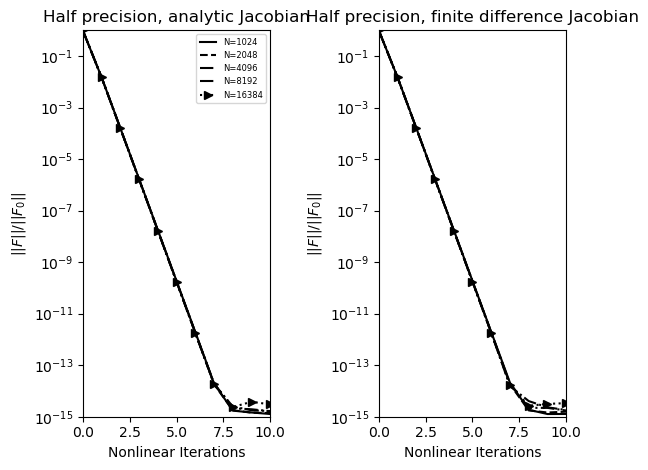

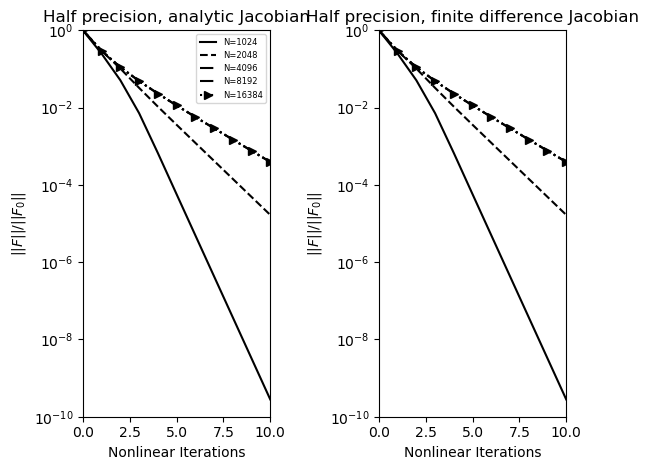

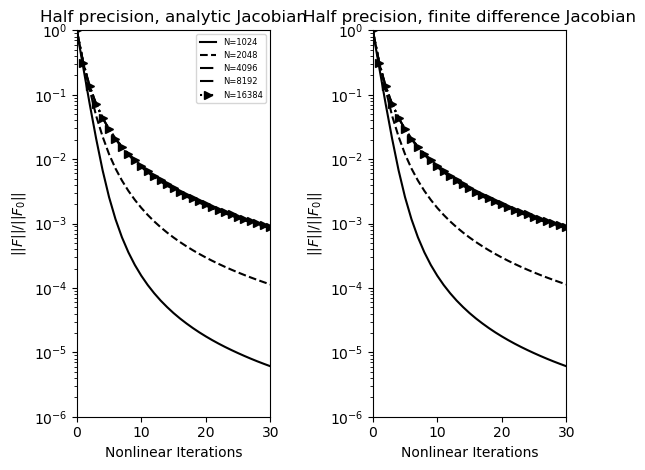

In [6]:
cd(MPRdir)
data_harvest("Data_From_Paper/MP_Data_") 

The three LaTeX tables are pretty vivid demonstrations that using a half-precision Jacobian is a poor idea. The columns are ratios of successive residual norms. Those ratios are supposed to go to zero if the convergence is q-superlinear. In the half precision case, it is not. You can also see that from the plots at the bottom.

In [7]:
cd(MPRdir)
data_harvest("Data_From_Paper/MP_Data_"; ptable=true) 

\begin{tabular}{llllll} 
        n &     1024 &     2048 &     4096 &     8192 &    16384 \\ 
\hline 
1 & 1.51548e-02 & 1.50894e-02 & 1.50458e-02 & 1.50240e-02 & 1.50131e-02   \\ 
2 & 1.07397e-02 & 1.06615e-02 & 1.06107e-02 & 1.05853e-02 & 1.05726e-02   \\ 
3 & 1.04864e-02 & 1.04099e-02 & 1.03607e-02 & 1.03361e-02 & 1.03238e-02   \\ 
4 & 1.04514e-02 & 1.03766e-02 & 1.03284e-02 & 1.03043e-02 & 1.02922e-02   \\ 
5 & 1.04464e-02 & 1.03721e-02 & 1.03239e-02 & 1.03001e-02 & 1.02881e-02   \\ 
6 & 1.04530e-02 & 1.03772e-02 & 1.03263e-02 & 1.02969e-02 & 1.02816e-02   \\ 
7 & 1.01305e-02 & 9.79786e-03 & 1.05554e-02 & 1.05224e-02 & 1.06917e-02   \\ 
8 & 8.73158e-02 & 9.79760e-02 & 1.09900e-01 & 1.31948e-01 & 1.24336e-01   \\ 
9 & 8.46876e-01 & 7.99843e-01 & 9.21406e-01 & 7.13501e-01 & 1.60623e+00   \\ 
10 & 8.73518e-01 & 9.65146e-01 & 8.40415e-01 & 9.29831e-01 & 7.88260e-01   \\ 
\hline 
\end{tabular} 
\begin{tabular}{llllll} 
        n &     1024 &     2048 &     4096 &     8192 &    16384 \\ 
